In [1]:
import torch.nn as nn

def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=1000):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x

In [51]:
import os
import torch
import lightning as L
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import datasets 
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
from torchvision import models
from matplotlib import pyplot as plt
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
from torchmetrics.image import StructuralSimilarityIndexMeasure
from pytorch_msssim import ssim
from torchvision.transforms.functional import resize

def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(len(images)):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx].cpu(), one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            str(preds[idx]),
            probs[idx] * 100.0,
            str(labels[idx])),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


class MobileNetTrainer(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = MobileNetV2(ch_in=3, n_classes=200)
        self.loss=nn.CrossEntropyLoss()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
        torch.set_float32_matmul_precision('high')
        
    def forward(self, inputs):
        return self.model(inputs)

    def training_step(self, batch, batch_idx):
        inputs = batch['image']
        target = batch['label']
        output = self(inputs.to(dtype=torch.float32))
        loss = self.loss(output, target.view(-1))
        self.log_dict({"train_loss": loss}, prog_bar=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        inputs = batch['image']
        target = batch['label']
        
        output = self(inputs.to(dtype=torch.float32))
        loss = self.loss(output, target.view(-1))
        self.log_dict({"val_loss": loss}, prog_bar=True)
        return loss
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=1e-5)

class LogEpochValidationImage(L.Callback):
    def __init__(self,reference):
        super().__init__()
        self.reference=reference
        
    def on_train_epoch_end(self, trainer, pl_module):
        tensorboard = trainer.logger.experiment
        z = pl_module.model(self.reference['image'][0:10].to('cuda').to(dtype=torch.float32))
        tensorboard.add_figure('predictions vs. actuals',
                            plot_classes_preds(pl_module.model, self.reference['image'][0:10].to('cuda').to(dtype=torch.float32),  self.reference['label'][0:10]),
                            global_step=trainer.current_epoch )

        # tensorboard.add_image("val",z.squeeze(0).squeeze(0),trainer.current_epoch,dataformats="HW")

class DataHuggingFace(utils.data.Dataset):
    def __init__(self, dataset):
        super(DataHuggingFace, self).__init__()
        self.dataset=dataset
        self.preprocess = torchvision.transforms.Compose([
            torchvision.transforms.Resize(64),
            torchvision.transforms.CenterCrop(64),
        ])
    def __len__(self):
        return self.dataset.shape[0]
    def __getitem__(self, idx):
        return self.preprocess(self.dataset['image'][idx]).to(dtype=torch.float32), self.dataset['label'][idx]
        



# Machine learning theory
## Bartosz Adamczyk 148163, Illia Vysochyn 150...

In [39]:
tiny_imagenet_train = datasets.load_dataset('Maysee/tiny-imagenet', split='train').cast_column("image", datasets.Image(mode="RGB")).with_format("torch")
tiny_imagenet_val = datasets.load_dataset('Maysee/tiny-imagenet', split='valid').cast_column("image", datasets.Image(mode="RGB")).with_format("torch")


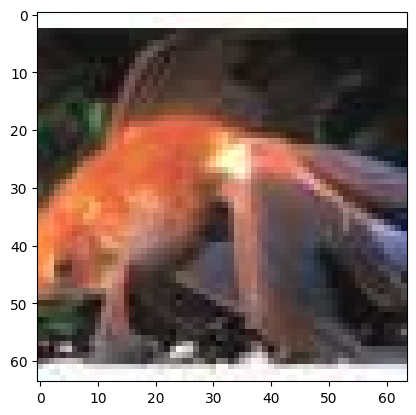

In [40]:
plt.imshow(tiny_imagenet_val['image'][0].permute(1,2,0))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params
-----------------------------------------------------------
0 | model | MobileNetV2                      | 2.5 M 
1 | loss  | CrossEntropyLoss                 | 0     
2 | ssim  | StructuralSimilarityIndexMeasure | 0     
-----------------------------------------------------------
2.5 M     Trainable params
0         Non-trainable params
2.5 M     Total params
9.920     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

ValueError: num must be an integer with 1 <= num <= 4, not 5

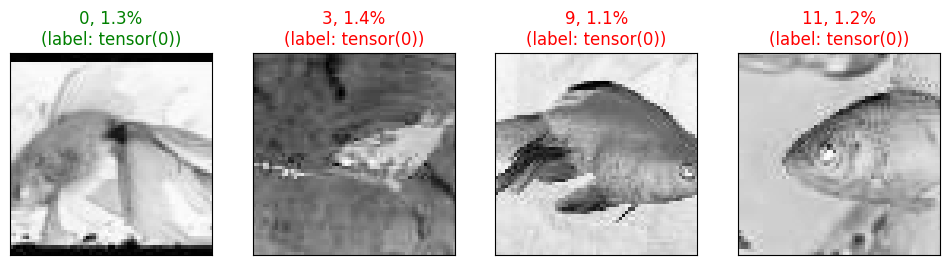

In [52]:

logger = TensorBoardLogger("tb_logs", name="mlt_log")
dataloader_train = utils.data.DataLoader(tiny_imagenet_train, batch_size=128,num_workers=24, shuffle=False)
dataloader_val = utils.data.DataLoader(tiny_imagenet_val, batch_size=128,num_workers=24,shuffle=False)

modelT = MobileNetTrainer()
# trainer = L.Trainer(max_epochs=26,callbacks=[EarlyStopping(monitor="val_loss",patience=3, mode="min"),LogEpochValidationImage(tiny_imagenet_val)],logger=logger)
trainer = L.Trainer(max_epochs=26,callbacks=[EarlyStopping(monitor="val_loss",patience=3, mode="min")],logger=logger)
trainer.fit(model=modelT, train_dataloaders=dataloader_train,val_dataloaders=dataloader_val)